# Q3

## Generate dataset

I set $\gamma = 0.01, \sigma_t = 1$. I set $T = 1000$

The following code modifies the provided notebook, mainly adding dimension to $y$, since H is now 2 by 3 matrix, and $y_t \in R^2$ at each $t$

([], [])

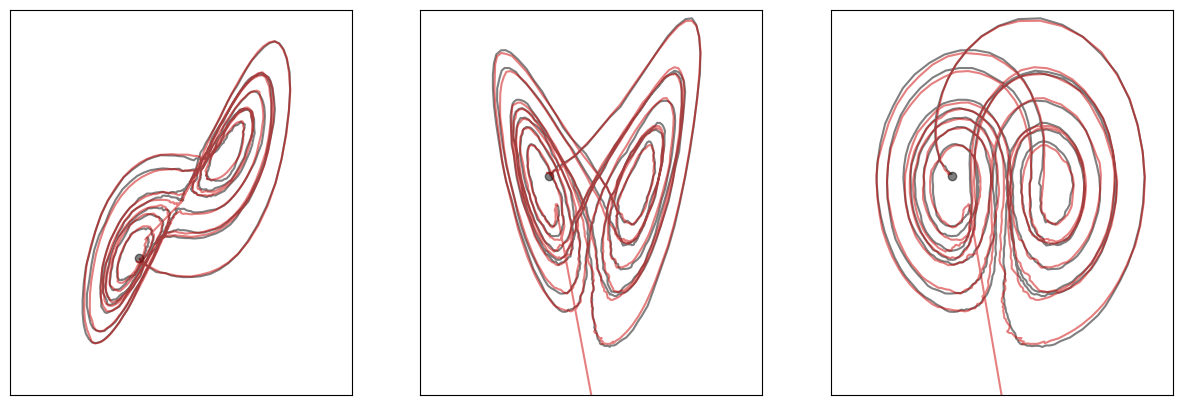

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Define the parameters of Lorenz 63
r = 28
b = 8/3
s = 10

# define the stochastic one step-ahead function with step size gam
def Lorenz63(x, r, s, b, gam):
    x1 = x[0] - gam * s * (x[0] - x[1]) + np.sqrt(gam) * np.random.normal(0, 1)
    x2 = x[1] + gam * (r * x[0] - x[1] - x[0] * x[2]) + np.sqrt(gam) * np.random.normal(0, 1)
    x3 = x[2] + gam * (x[0] * x[1] - b * x[2]) + np.sqrt(gam) * np.random.normal(0, 1)

    return np.array([x1, x2, x3])


gam = 0.01
T = 1000
ts = 10

X_lorenz = np.zeros((3, T))
y_lorenz = np.zeros((2, T))

X_lorenz[:, 0] = np.array([-5.91652, -5.52332, 24.5723]).T
H = np.zeros((2, 3))
H[0, 0] = 1
H[-1, -1] = 1

sig_y = 1
y_lorenz[:, 0] = H @ X_lorenz[:, 0] + sig_y * np.random.normal(0, 1, (2,))

# Generate the true trajectory and the observations
for t in range(1, T):
    X_lorenz[:, t] = Lorenz63(X_lorenz[:, t-1], r, s, b, gam)
    y_lorenz[:, t] = H @ X_lorenz[:, t] + sig_y * np.random.normal(0, 1, (2,))

# Plot the true trajectory and the observations
N = 1000
x_particles_pred = np.zeros((3, N))
w = np.ones(N) / N
x_particles = np.random.multivariate_normal(X_lorenz[:, 0], np.eye(3), N).T # (3, N)
x_est = np.zeros((3, T))

for t in range(1, T):
    for i in range(N):
        x_particles_pred[:, i] = Lorenz63(x_particles[:, i], r, s, b, gam)
    diff = y_lorenz[:, t][:, np.newaxis] - H @ x_particles_pred
    logw = -0.5 * np.sum(diff**2, axis=0) / sig_y**2
    logw = logw - np.max(logw)
    w = np.exp(logw) / np.sum(np.exp(logw))

    x_est[:, t] = np.sum(x_particles_pred * w[np.newaxis, :], axis=1)
    x_particles= x_particles_pred[:, np.random.choice(N, N, p=w)]

t = T - 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(X_lorenz[0, 0:t], X_lorenz[1, 0:t], c = 'k', alpha=0.5)
plt.plot(X_lorenz[0, t], X_lorenz[1, t], 'o', c = 'k', alpha=0.5)
plt.plot(x_est[0, 0:t], x_est[1, 0:t], color = [0.8, 0, 0], alpha=0.5)
plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.plot(X_lorenz[0, 0:t], X_lorenz[2, 0:t], c = 'k', alpha=0.5)
plt.plot(X_lorenz[0, t], X_lorenz[2, t], 'o', c = 'k', alpha=0.5)
plt.plot(x_est[0, 0:t], x_est[2, 0:t], color = [0.8, 0, 0], alpha=0.5)
plt.xlim([-30, 30])
plt.ylim([0, 50])
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.plot(X_lorenz[1, 0:t], X_lorenz[2, 0:t], c = 'k', alpha=0.5)
plt.plot(X_lorenz[1, t], X_lorenz[2, t], 'o', c = 'k', alpha=0.5)
plt.plot(x_est[1, 0:t], x_est[2, 0:t], color = [0.8, 0, 0], alpha=0.5)
plt.xlim([-30, 30])
plt.ylim([0, 50])
# remove boxes and all ticks from the plots
plt.xticks([])
plt.yticks([])

## Q3.1 pMCMC

I set K=500, N=100.

Let $\theta = [s, r, b]$, let $\tau_{\theta}(x_t|x_{t-1})$ denote the Lorenz 63 model, 
let $g_{\theta}(y_t|x_t) = \mathcal{N}(Hx, \sigma_y^2)$ denote the likelihood function.

I set the proposal function as

$$
q(\cdot | \theta_{k-1}) = \mathcal{N}(\theta_{k-1}, \sigma_{prop})
$$

Where S, R, B have $\sigma_{prop} = 2, 1, 1$ respectively

The Particle MCMC pseudocode is given by

Init: Sample $\theta_0 \sim p_0$, the prior (will be explained below)

**for** $k = 1, ..., K$ **do**:

- Sample:
$\theta^\prime \sim q(\cdot | \theta_{k-1})$

- Run pariticle filter to obtain $p^N (y_{1:T} | \theta^\prime)$:  
Set $ x_0^{(i)} = (5.91652, -5.52332, 24.5723) $ for $ i = 1, \ldots, N. $  

    **for** $ t = 1, \ldots, T $ **do**
    - Sample:
    $ 
    \bar{x}_t^{(i)} \sim \tau_{\theta^\prime}(\cdot|x_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. 
    $

    - Weight:
    $
    W_t^{(i)} = g_{\theta^\prime}(y_t|\bar{x}_t^{(i)}),
    $
    for $ i = 1, \ldots, N $.

    - Store:
    $
    p^N(y_t|y_{1:t-1}, \theta^\prime) = \frac{1}{N} \sum_{i=1}^{N} W_t^{(i)}
    $

    - Normalize
    $
    w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
    $

    - Resample: 
    Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(N)}$ ),
    and set $ x_t^{(i)} = \bar{x}_t^{(o_t(i))} $ for $ i = 1, \ldots, N $.

    Return $p^N(y_{1:n} | \theta^\prime) = \prod_{k=1}^{t} p^N(y_k|y_{1:k-1}, \theta^\prime)$


- Accept with probability $\alpha(\theta_{k-1}, \theta^\prime) = \min (1, \frac{p^N (y_{1:T} | \theta^\prime)p_0(\theta^\prime)q(\theta_{k-1} | \theta^\prime)}{p^N (y_{1:T} | \theta_{k-1}) p_0(\theta_{k-1}) q(\theta^\prime | \theta_{k-1}) })$ and set $\theta_k = \theta^\prime$
                                        
**end for**

In particular, we assume Uniform for each of $s, r, b$:

\begin{align*}
s &\sim Unif(9, 11) \\
r &\sim Unif(25, 35) \\
b &\sim Unif(0, 5)
\end{align*}

The reason for using such a tight range is that otherwise, the log weight may blow up as $g(y|x)$ is too small, causing the whole chain to blow up. This is a highly unstable system.

In [2]:
def log_prior(s, r, b):
    if 9 < s < 11 and 25 < r < 35 and 0 < b < 5:
        return 0  # log(1)
    else:
        return -np.inf

In [14]:
def BPF_q3(y, theta, N=1000):
    s, r, b = theta
    T = y.shape[1]
    x_particles = np.random.multivariate_normal(X_lorenz[:, 0], np.eye(3), N).T
    x_particles_pred = np.zeros((3, N))
    loglik = 0.0
    for t in range(T):
        for i in range(N):
            x_particles_pred[:, i] = Lorenz63(x_particles[:, i], r, s, b, gam)
        diff = y[:, t][:, np.newaxis] - H @ x_particles_pred
        logw = -0.5 * np.sum(diff**2, axis=0) / sig_y**2

        # compute average weight using log-sum-exp trick
        # log sum exp( log W) - log N
        max_log = np.max(logw)
        log_sum = np.log(np.sum(np.exp(logw - max_log))) + max_log

        if log_sum < -1e10:
            print(f'log_sum is too small at time step {t}, setting uniform weights.')
            w = np.ones(N) / N
            logw = np.log(w)
            log_sum = 0
        else:
            loglik += log_sum - np.log(N)

        # Normalize log-weights in log-domain
        # same as weights /= np.sum(weights)

        logw -= log_sum
        w = np.exp(logw)

        if abs(sum(w) - 1) > 1e-5:
            print(f'Weights do not sum to 1 at time step {t}')
        if np.any(np.isnan(w)):
            print(f'Weights contain NaN at time step {t}')
            print(f'logw: {logw}')
            print(f'log_sum: {log_sum}')

        x_particles= x_particles_pred[:, np.random.choice(N, N, p=w)]
    return loglik

In [4]:
def log_proposal(theta_new, theta_old, prop_sig):
    '''q(theta_new | theta_old)'''
    diff = theta_new - theta_old
    mahalanobis = np.sum((diff / prop_sig) ** 2)  # Use variance
    log_det = 2 * np.sum(np.log(prop_sig))        # Since variance = std^2

    d = len(theta_new)
    log_pdf = -0.5 * (mahalanobis + d * np.log(2 * np.pi) + log_det)
    return log_pdf


In [15]:
def pMCMC(y, prop_sig, K=1000, N=1000):

    s, r, b = np.random.uniform(9, 11), np.random.uniform(25, 35), np.random.uniform(0, 5)
    theta_curr = np.array([s, r, b])
    theta_samples = []

    loglik_curr = BPF_q3(y, theta_curr, N)
    logprior_curr = log_prior(s, r, b)
    for _ in range(K):
        # print('Current theta:', theta_curr)
        theta_prop = np.random.multivariate_normal(theta_curr, np.diag(prop_sig**2))
        print('Proposed theta:', theta_prop)
        logprior_prop = log_prior(s, r, b)
        loglik_prop = BPF_q3(y, theta_prop, N)
        print('Proposed loglik:', loglik_prop)
        if logprior_prop > -np.inf:
            log_q_curr = log_proposal(theta_prop, theta_curr, prop_sig) # q(theta_curr | theta_prop)
            log_q_prop = log_proposal(theta_curr, theta_prop, prop_sig) # q(theta_prop | theta_curr)

            # print('up side')
            # print(loglik_prop, logprior_prop, log_q_curr)
            # print('down side:')
            # print(loglik_curr, logprior_curr, log_q_prop)

            # note log_q_curr and log_q_prop are the same due to symmetry of Gaussian proposal
            print('loglik_curr:', loglik_curr, 'loglik_prop:', loglik_prop)
            log_ratio = (loglik_prop + logprior_prop) - (loglik_curr + logprior_curr)
            print(log_ratio, 'log ratio')
            U = np.random.rand()
            if np.log(U) < log_ratio:
                print('Accept')
                theta_curr = theta_prop
                loglik_curr = loglik_prop
                logprior_curr = logprior_prop
        theta_samples.append(theta_curr)

    return np.array(theta_samples)

In [ ]:
import os

if os.path.exists('theta_samples.npy'):
    print("theta samples exists!")
else:
    theta_samples = pMCMC(y_lorenz, K=500, N=100, prop_sig=np.array([2, 1, 1]))
    np.save('theta_samples.npy', theta_samples)


theta samples exists!


In [20]:

theta_samples = np.load('theta_samples.npy')

theta_samples.shape

(500, 3)

### Traceplot

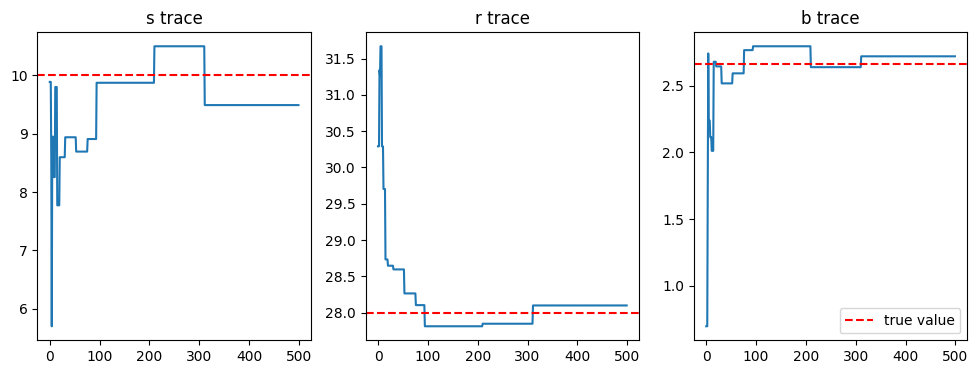

In [17]:
plt.figure(figsize=(12, 4))
labels = ['s','r', 'b']
true_vals = [s, r, b]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(theta_samples[:, i])
    # mark true value
    plt.axhline(y=true_vals[i], color='r', linestyle='--', label='true value')
    plt.title(f"{labels[i]} trace")
plt.legend()
plt.show()

### Posterior histogram for 2D marginal

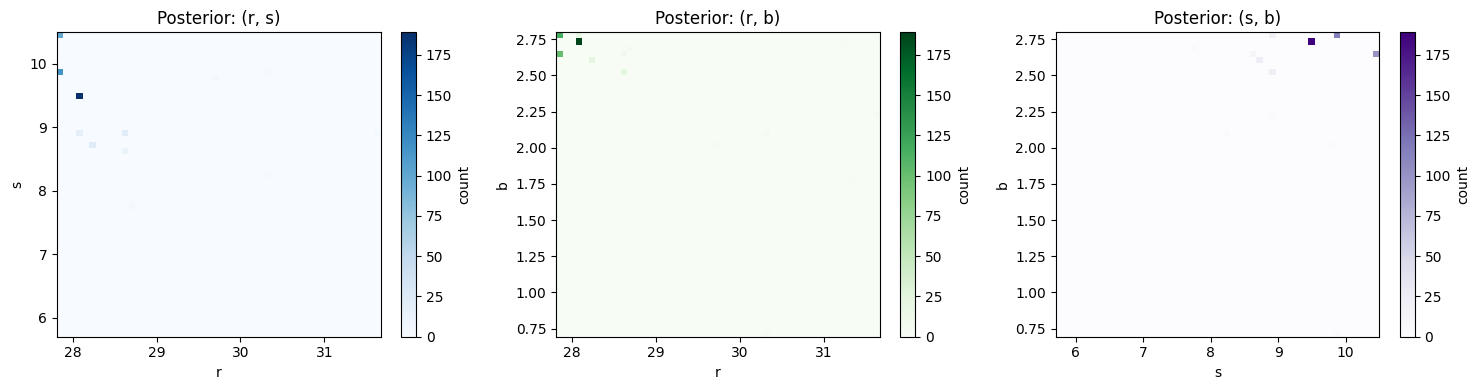

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose theta_samples.shape == (3, T)
s_samples = theta_samples[:, 0]
r_samples = theta_samples[:, 1]
b_samples = theta_samples[:, 2]

plt.figure(figsize=(15, 4))

# (r, s)
plt.subplot(1, 3, 1)
plt.hist2d(r_samples, s_samples, bins=50, cmap='Blues')
plt.xlabel('r')
plt.ylabel('s')
plt.title('Posterior: (r, s)')
plt.colorbar(label='count')

# (r, b)
plt.subplot(1, 3, 2)
plt.hist2d(r_samples, b_samples, bins=50, cmap='Greens')
plt.xlabel('r')
plt.ylabel('b')
plt.title('Posterior: (r, b)')
plt.colorbar(label='count')

# (s, b)
plt.subplot(1, 3, 3)
plt.hist2d(s_samples, b_samples, bins=50, cmap='Purples')
plt.xlabel('s')
plt.ylabel('b')
plt.title('Posterior: (s, b)')
plt.colorbar(label='count')

plt.tight_layout()
plt.show()


### Autocorrelation Plot

/var/folders/fd/vr4zygtx6jxftqb9dm5hvstw0000gn/T/ipykernel_48528/2973420928.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(lags + 1), acf_vals, use_line_collection=True)


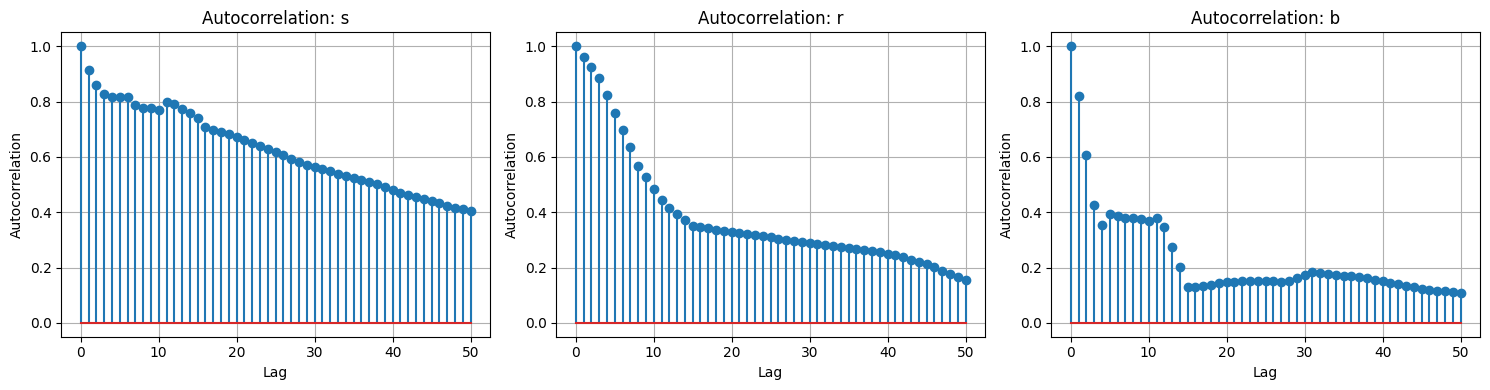

In [22]:
from statsmodels.tsa.stattools import acf
# Autocorrelation plots
lags = 50  # number of lags to show

def plot_autocorr(samples, label):
    acf_vals = acf(samples, nlags=lags)
    plt.stem(range(lags + 1), acf_vals, use_line_collection=True)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation: {label}')
    plt.grid(True)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_autocorr(s_samples, 's')

plt.subplot(1, 3, 2)
plot_autocorr(r_samples, 'r')

plt.subplot(1, 3, 3)
plot_autocorr(b_samples, 'b')

plt.tight_layout()
plt.show()

## Q3.2

Again for NPF we have pseudocode:

Let $\theta = (S, R, B)$.  
We use this prior:

\begin{align*}
s &\sim Unif(0, 20) \\
r &\sim Unif(0, 50) \\
b &\sim Unif(0, 10)
\end{align*}

Let proposal kernal $\kappa(\cdot|\theta_{t-1}^{(i)}) = \mathcal{N}(0, \sigma=0.001)$  

**Sample:**  $ \hat{\theta}_0^{(i)} \sim p_0(\theta) $ 
for $ i = 1, \ldots, M $.

**Init:** 
Since we know $x_0$ from the Lorenz model, set
$ \bar{x}_t^{(i, j)} \sim \mathcal{N}(x_0; 0, I_3)
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M. $


**for** $ t = 1, \ldots, T $ **do**

- Propose 
$ \hat{\theta}_t^{(i)} \sim \kappa(\cdot|\theta_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, M. $

- Sample Inner layer:
$ \bar{x}_t^{(i, j)} \sim \tau_{\hat{\theta}_t^{(i)}}(\cdot|x_{t-1}^{(i, j)}) \quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M. $

- Weight:
$
V_t^{(i, j)} = g(y_t|\bar{x}_t^{(i, j)}),
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M $.

- Normalize
$
v_t^{(i,j)} = \frac{V_t^{(i,j)}}{\sum_{j=1}^N V_t^{(i,j)}},
$

- Approximate outler layer:
$
W_t^{(i)} = \frac{1}{N} \sum_{j=1}^N v_t^{(i,j)}
$

- Normalize
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^M W_t^{(j)}},
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample Inner particles
$
\tilde{x}_t^{(i,j)} \sim \sum_{j=1}^N v_t^{(i,j)} \delta_{\bar{x}_t^{(i,j)}}, 
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(M)}$ ),
and set 

\begin{align*}
\theta_t^{(i)} =& \hat{\theta}_t^{(o_t(i))}\\
x_t^{(i,j)} =& \bar{x}_t^{(o_t(i), j)}
\end{align*}

for $ j = 1, \ldots, N $.

Return $ \{\theta_T^{(i)}\}_{i=1}^M$, and approximate posterior by 

$$
p(\mathrm{d}\theta|y_{1:T}) \approx \frac{1}{M} \sum_{i=1}^M \delta_{\theta_T^{(i)}}(\mathrm{d}\theta)
$$

In [36]:
def log_proposal(x, y):
    '''g(y|x) = N(y, Hx, sig_y^2)'''
    # x: shape (3, N, M), N particles, M parameters
    # y: shape (2,)
    # H: shape (2, 3), sig_y: scalar

    N, M = x.shape[1], x.shape[2]
    log_V = np.zeros((M, N))

    for i in range(M):
        mean = H @ x[:, :, i] # shape (2, N)
        diff = y[:, np.newaxis] - mean # shape (2, N)
        logw = -0.5 * np.sum(diff**2, axis=0) / sig_y**2 # shape (N,)
        log_V[i] = logw
    return log_V # shape (M, N)

In [46]:
def npf_q3(Y, M=100, N=100, proposal_std=0.001):
    # r, s, b = theta
    T = Y.shape[1]

    # Initial samples from p0(theta)
    S_samples = np.random.uniform(0, 20, size=M)  # Initial samples from p0(theta)
    R_samples = np.random.uniform(0, 50, size=M)  # Initial samples from p0(theta)
    B_samples = np.random.uniform(0, 10, size=M)  # Initial samples from p0(theta)

    S_particles = np.zeros((T, M))
    R_particles = np.zeros((T, M))
    B_particles = np.zeros((T, M))
    S_estimates = np.zeros(T)  # Store estimates of theta over time
    R_estimates = np.zeros(T)  # Store estimates of theta over time
    B_estimates = np.zeros(T)  # Store estimates of theta over time
    
    # Initialize inner particles for each outer particle
    # x_particles = np.random.normal(m0, np.sqrt(P0), size=(M, N))
    # x_particles = np.random.multivariate_normal(x[:, 0], np.eye(3), N).T
    particles = np.random.multivariate_normal(X_lorenz[:, 0], np.eye(3), N).T  # shape (3, N)
    x_particles = np.repeat(particles[:, :, np.newaxis], M, axis=2)     # shape (3, N, M)
    x_particles_pred = np.zeros((3, N, M))
    
    for t in range(T):
        y = Y[:, t]
        
        # Step 1: Propose new theta from proposal kernel
        S_proposed = S_samples + np.random.normal(0.0, proposal_std, size=M)
        R_proposed = R_samples + np.random.normal(0.0, proposal_std, size=M)
        B_proposed = B_samples + np.random.normal(0.0, proposal_std, size=M)

        x_particles_pred = np.zeros((3, N, M))
        log_V = np.zeros((M, N))
        V = np.zeros((M, N)) # to store unnormalized weights
        for i in range(M):
            # Step 2: Propagate inner particles using tau = lorenz63
            for j in range(N):
                x_particles_pred[:, j, i] = Lorenz63(x_particles[:, j, i], S_proposed[i], R_proposed[i], B_proposed[i], gam)
            # Step 3: Weight update using likelihood g = N(Hx, sig_y^2)

            log_V = log_proposal(x_particles_pred, y)
            V[i] = np.exp(log_V[i])

        # Step 4: Normalize inner weights (log domain for stability)
        v = np.zeros((M, N))
        for i in range(M): # normalize each row
            max_log = np.max(log_V[i])
            log_sum = np.log(np.sum(np.exp(log_V[i] - max_log))) + max_log
            log_V[i] -= log_sum  # log-normalize
            v[i] = np.exp(log_V[i])  # normalized weights
        
        # Step 5: Compute outer weights as average inner weights
        W = np.mean(V, axis=1)  # shape (M,)
        W /= np.sum(W)  # normalize outer weights


        # Step 6: Resample inner particles according to v
        x_tilde = np.zeros((3, N, M))  # shape should match x_particles_pred
        for i in range(M):
            indices = np.random.choice(N, size=N, p=v[i])
            x_tilde[:, :, i] = x_particles_pred[:, indices, i]  # correct indexing and broadcasting


        # Step 7: Resample outer particles according to W
        o = np.random.choice(M, size=M, p=W)

        S_particles[t] = S_proposed[o]          # Resample outer particles
        R_particles[t] = R_proposed[o]          # Resample outer particles
        B_particles[t] = B_proposed[o]          # Resample outer particles
        x_particles = x_tilde[:, :, o]  # shape (3, N, M)

        S_estimates[t] = np.mean(S_particles[t])  # Store mean theta over time
        R_estimates[t] = np.mean(R_particles[t])  # Store mean theta over time
        B_estimates[t] = np.mean(B_particles[t])  # Store mean theta over time


    return S_estimates, R_estimates, B_estimates


In [47]:
X_lorenz.shape, y_lorenz.shape

((3, 1000), (2, 1000))

In [48]:
S_estimates, R_estimates, B_estimates = npf_q3(y_lorenz, M=100, N=100, proposal_std=0.001)
S_estimates.shape, R_estimates.shape, B_estimates.shape

((1000,), (1000,), (1000,))

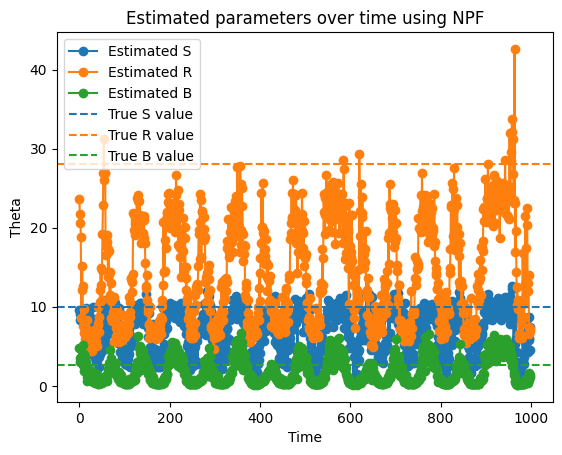

In [56]:
import matplotlib.pyplot as plt

# Plot estimated values and capture line objects
line_s, = plt.plot(S_estimates, label='Estimated S', marker='o')
line_r, = plt.plot(R_estimates, label='Estimated R', marker='o')
line_b, = plt.plot(B_estimates, label='Estimated B', marker='o')

# Get the colors
colors = [line_s.get_color(), line_r.get_color(), line_b.get_color()]

# Add true value lines using matching colors
true_vals = [s, r, b]
labels = ['S', 'R', 'B']
for i in range(3):
    plt.axhline(y=true_vals[i], linestyle='--', color=colors[i], label=f'True {labels[i]} value')

# Finish plotting
plt.title('Estimated parameters over time using NPF')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.legend()
plt.show()

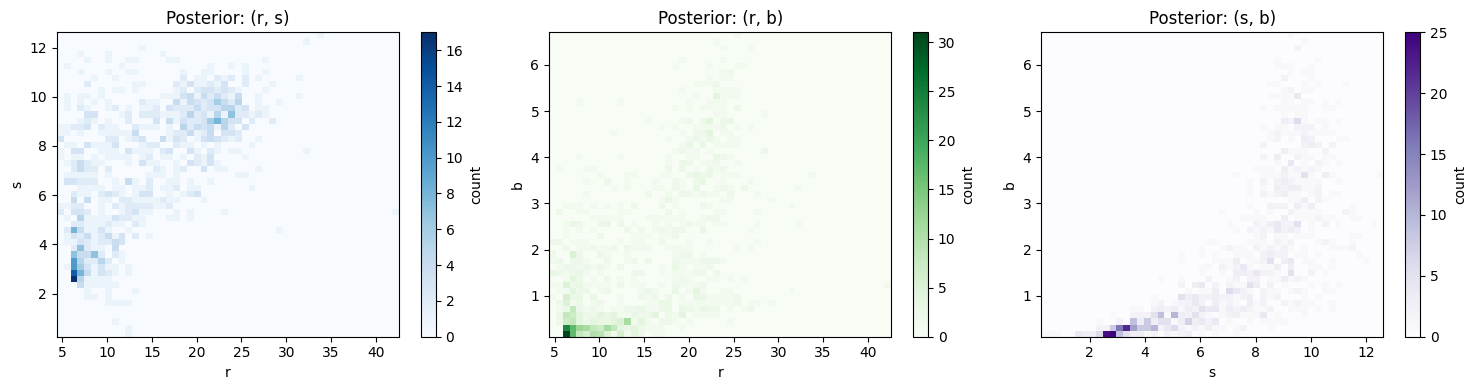

In [54]:
plt.figure(figsize=(15, 4))

# (r, s)
plt.subplot(1, 3, 1)
plt.hist2d(R_estimates, S_estimates, bins=50, cmap='Blues')
plt.xlabel('r')
plt.ylabel('s')
plt.title('Posterior: (r, s)')
plt.colorbar(label='count')

# (r, b)
plt.subplot(1, 3, 2)
plt.hist2d(R_estimates, B_estimates, bins=50, cmap='Greens')
plt.xlabel('r')
plt.ylabel('b')
plt.title('Posterior: (r, b)')
plt.colorbar(label='count')             

# (s, b)
plt.subplot(1, 3, 3)        
plt.hist2d(S_estimates, B_estimates, bins=50, cmap='Purples')
plt.xlabel('s')
plt.ylabel('b')
plt.title('Posterior: (s, b)')
plt.colorbar(label='count')
plt.tight_layout()
plt.show()


/var/folders/fd/vr4zygtx6jxftqb9dm5hvstw0000gn/T/ipykernel_44599/1242163961.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(lags + 1), acf_vals, use_line_collection=True)


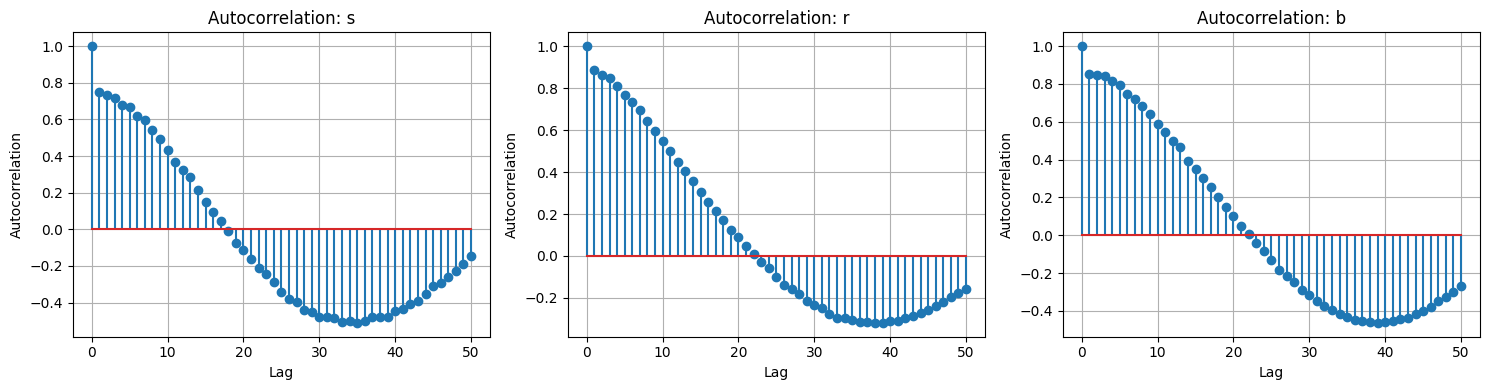

In [55]:
# import acf
from statsmodels.tsa.stattools import acf
# Autocorrelation plots
lags = 50  # number of lags to show

def plot_autocorr(samples, label):
    acf_vals = acf(samples, nlags=lags)
    plt.stem(range(lags + 1), acf_vals, use_line_collection=True)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation: {label}')
    plt.grid(True)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_autocorr(S_estimates, 's')

plt.subplot(1, 3, 2)
plot_autocorr(R_estimates, 'r')

plt.subplot(1, 3, 3)
plot_autocorr(B_estimates, 'b')

plt.tight_layout()
plt.show()